# Machine Learning on MNIST data in Julia using KNN
> Development of machine learning model (KNN) on MNIST data in Julia

- toc: true
- badges: true
- hide_binder_badge: true
- hide_colab_badge: true
- hide_github_badge: true
- comments: true
- categories: [machinelearning, Julia, MNIST, KNN]
- hide: false
- search_exclude: true
- author: Omer

In this tutorial, we are going to develop a machine learning system (KNN) for recognizing digits (0 to 9) from MNIST dataset.


Let's start by including all the necessary packages.

In [2]:
using MLDatasets # for MNIST data
using Images     # for display of Images
using Plots      # for multiple image display in single figure
using Flux       # for loss function

We are using 

1. `MLDatasets` package to access the MNIST dataset.
2. `Image` package to visualize images
3. `Plots` package to visualize images in sub-plot scheme
4. `Flux`  package for loss function

## Downloading dataset

Let's go ahead with downloading of a full MNIST data using `MLDatasets` package. Once the dataset is downloaded on local machine we load it into train and test variable. 

- __xtrain__ : triaing images
- __ytrain__ : class label for training images
- __xtest__  : testing images
- __ytest__  : class label for testing images



{% include alert.html text="It may take some time if you are downloading dataset for the first time" %} 

In [3]:
xtrain, ytrain = MNIST.traindata(Float32);
xtest, ytest = MNIST.testdata(Float32);

We can now see the dimensions and type of MNIST data

In [61]:
println("Train data size $(size(xtrain)) with $(size(ytrain)) Labels")
println("Test data size $(size(xtest)) with $(size(ytest)) Labels")
println("Type of data $(typeof(xtrain))")

Train data size (28, 28, 60000) with (60000,) Labels
Test data size (28, 28, 10000) with (10000,) Labels
Type of data Array{Float32,3}


Let's visualize an image from training set.

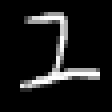

In [5]:
Gray.(xtrain[:,:,3])

MNIST dataset stores images in horizontal-major compared to usual vertical-major alignment. Therefor to show the image properly (in verticle alignment) we need to use the `convert2image` function (provided by the MNIST dataset).

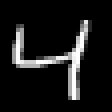

In [62]:
MNIST.convert2image(xtrain[:,:,3])

Important >  We are using Gray function to convert Array{Float32,2} data to Array{ColorTypes.Gray{Float32,2}}. If we do not do this, Juno/IJulia will show it as an array of numbers rather then showing it as an image. The .dot notation is used to apply the operation elements-wise

And to show it in inverted colours

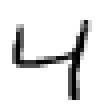

In [63]:
Gray.(1 .- MNIST.convert2image(xtrain[:,:,3]))

## Train and Test Data statistics 

Let's see some basic statisitcs on train and test data. 

1. __Counting examples per class in train/test dataset__

In [64]:
cats = sort!(unique(ytrain)) # Classes
count_per_class_train_data = zeros(Int32, length(cats))
count_per_class_test_data  = zeros(Int32, length(cats))

for i in ytrain
    count_per_class_train_data[i+1] += 1
end

for i in ytest
    count_per_class_test_data[i+1] += 1
end

println("classes :",cats,"\n")
println("Number of exmaples in train data per class : \n",count_per_class_train_data,"\n")
println("Number of exmaples in test data per class : \n",count_per_class_test_data,"\n")



classes :[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Number of exmaples in train data per class : 
Int32[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

Number of exmaples in test data per class : 
Int32[980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]



2. __Mean image per class__

In [65]:
mean_stk_img = [] # mean image per class in vertical-major form
for i in cats
    global mean_img_stk
    mn_img = mean(xtrain[:,:,(ytrain .== i)], dims=3);
    img = Gray.(1 .- MNIST.convert2image(mn_img[:,:,1]))
    push!(mean_stk_img, img) # stacking of images
end

Let's display mean image per class in subplot scheme

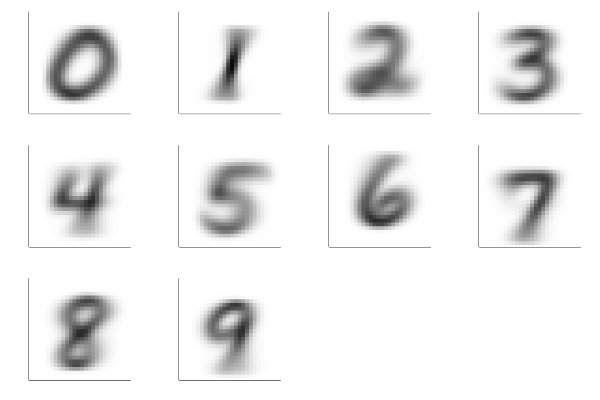

In [67]:

p = plot(axis=nothing, layout=10)
for i = 1:10
    plot!(p[i],mean_stk_img[i])
end
p

## Machine Learning using KNN

KNN stands for K Nearest Neighbour. The model belongs to a family of supervised machine learning (ML) algorithms and can be used for both classification and regression problems. However, the present context of MNIST dataset, we are going to use it as a classifier. The KNN ML algorithm works on a simple concept of _similarity_ between two sets (reference set and test set). The similarity can be __pixel__ based or __feature__ based. In this tutorial, we will take a simpler case of __pixel similarity__. For our current problem of MNIST data classification, we make the following design choices
 1. We use K=1
 2. We use images to represent our sets. Images from training data will form our reference set and images from test data will form our test set. 

The algorithm is implemented as follows
 
### Training
- For each class (0,1,2,3,...9), we compute a mean image by taking an average of all train images in that class 
- This will result in 10 mean images. 
- Taken together these 10 mean images makeup our model


In [68]:
# Training
mean_stk = [] # mean per class in horizontal-major form
for i in cats
    global mean_stk
    mn_img = mean(xtrain[:,:,(ytrain .== i)], dims=3);
    push!(mean_stk, mn_img[:,:,1]) # stacking of Arrays
end

 ### Testing
To predict a class label (0,1,2...9) of a given test image, we use __pixel similarity__. We can use different metrics for similarity but a simpler one is a _distance metric_. There are two commonly used options for distance metric:

   - L1 Norm: Mean absolute difference between pixel values
   - L2 Norm: Mean of squared differences followed by square root (also called as RMSE)
   
 Let's take a single example image of `digit 0` from test data and apply these distance metric

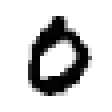

In [69]:
im_0 = xtest[:,:,findfirst(isequal(0),ytest)];
Gray.(1 .- MNIST.convert2image(im_0[:,:,1])) #display image

We can either implement `L1` and `L2` norm or use the existing functions from `Flux` or `Images` package. Both will give us the same answer

In [70]:
# Our Implementation

l1_dist_0 = abs.(im_0 - mean_stk[1])
l1_dist_0 = mean(l1_dist_0[:])

l2_dist_0 = (abs.(im_0 - mean_stk[1])).^2
l2_dist_0 = sqrt(mean(l2_dist_0[:]))

print("L1: $l1_dist_0, L2: $l2_dist_0  (Our Implementation)")

L1: 0.1284025, L2: 0.21966754  (Our Implementation)

In [71]:
# Using existing functions from Flux and Images Packages

flux_l1_dist_0 = Flux.Losses.mae(im_0, mean_stk[1])
flux_l2_dist_0 = sqrt(Flux.Losses.mse(im_0, mean_stk[1]))
println("L1: $flux_l1_dist_0, L2: $flux_l2_dist_0    (Flux Package)")

images_l1_dist_0 = Images.mae(im_0, mean_stk[1])
images_l2_dist_0 = Images.mse(im_0, mean_stk[1])
println("L1: $images_l1_dist_0, L2: $l2_dist_0    (Images Package)")


L1: 0.1284025, L2: 0.21966754    (Flux Package)
L1: 0.1284025, L2: 0.21966754    (Images Package)


Let's apply the metric on complete test data

In [72]:
total_test_ims = size(xtest,3)
total_cats = length(cats)

per_image_score_L1  = zeros(Int64, total_test_ims)
per_image_score_L2  = zeros(Int64, total_test_ims)
per_digit_score_l1  = zeros(Int64, total_cats)
per_digit_score_l2  = zeros(Int64, total_cats)

for i = 1:total_test_ims

    per_cat_score_L1 = []
    per_cat_score_L2 = []
    for m in mean_stk
        push!(per_cat_score_L1,Flux.Losses.mae(xtest[:,:,i],m))
        push!(per_cat_score_L2,sqrt(Flux.Losses.mse(xtest[:,:,i],m)))
    end
    
    per_image_score_L1[i] = argmin(per_cat_score_L1)-1
    per_image_score_L2[i] = argmin(per_cat_score_L2)-1
end

We can now display the class-wise accuracy, both L1 and L2 metric, for complete test set.

In [73]:
for i =0:9
    a = sum(per_image_score_L1[ytest.==i].==i)/count_per_class_test_data[i+1]
    b = sum(per_image_score_L2[ytest.==i].==i)/count_per_class_test_data[i+1]
    println(" Test Accuracy for digit $(cats[i+1]) : L1(", round(a*100, digits=2), "%),  L2(", round(b*100, digits=2), "%)")
end

 Test Accuracy for digit 0 : L1(81.53%),  L2(89.59%)
 Test Accuracy for digit 1 : L1(99.82%),  L2(96.21%)
 Test Accuracy for digit 2 : L1(42.34%),  L2(75.68%)
 Test Accuracy for digit 3 : L1(60.89%),  L2(80.59%)
 Test Accuracy for digit 4 : L1(66.8%),  L2(82.59%)
 Test Accuracy for digit 5 : L1(32.62%),  L2(68.61%)
 Test Accuracy for digit 6 : L1(78.71%),  L2(86.33%)
 Test Accuracy for digit 7 : L1(76.46%),  L2(83.27%)
 Test Accuracy for digit 8 : L1(44.25%),  L2(73.72%)
 Test Accuracy for digit 9 : L1(77.6%),  L2(80.67%)


A simple mean-per-class model seems to be performing very well for digits. To see errors in predictions, we can build a __Confusion Matrix__. The idea of a confusion matrix is to show true positive and false negative for each class. The rows (y-axis) usually shows predictions and columns (x-axis) shows the actual class.

In [74]:
function confusionMatrix(ŷ, y)
    cm = zeros(Int16, length(cats), length(cats))
    zbi = 1 # Since its 1 based indexing but our cats are starting from zero so add 1
    for (i,j) in zip(ŷ, y)
        cm[j+zbi, i+zbi] = cm[j+zbi, i+zbi] + 1 
    end
    return cm
end

confusionMatrix(per_image_score_L2, ytest)

10×10 Array{Int16,2}:
 878     0    7    2    2   58   25    1    7    0
   0  1092   10    3    0    7    3    0   20    0
  19    71  781   33   31    3   23   18   50    3
   4    24   25  814    1   49    8   15   58   12
   1    22    2    0  811    3   16    1   10  116
  11    63    2  118   21  612   27   10   13   15
  18    27   22    0   31   32  827    0    1    0
   2    59   22    1   20    2    0  856   13   53
  14    39   11   83   12   36   13   10  718   38
  15    22    7   10   83   12    1   27   18  814

Here we can see that `row 1` shows 878 true positives (predicted class `0` is the same as actual class `0`) and 102 false negatives (predicted class is different than actual class `0`)

This finishes our tutorial on applying KNN (K=1) to MNIST dataset in Julia. In the next tutorial, we will apply deep learning to see if it significantly improves per-class accuracy